In [30]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

def tidy_split(df, column, sep=';', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df.reset_index(drop=True)


In [31]:
df = pd.read_excel("clabsi.xlsx")
df = df.replace(np.NaN,'N/A')
columns = ["facility","NYU_EPIC_LOCATION"]


"""
data_frame: the table we are using for the data

columns: the headers, in order, for the columns we are creating links between

start: If all the links need to come from a single source that is not already in the dataset,
what will it be called?

missing_values: a list or tuple containing possible missing values (like N/A). Since np.nan != np.nan,
np.nan cannot be a missing value.

suffix: If there are repeated values between columns, to prevent looping back, add the column header as 
a suffix.
"""
def create_sankey(data_frame,columns,start=None,missing_values=(),suffix=False):
    table = data_frame[columns]
    if(start != None):
        table.insert(0,"Start",start)
    delimiter = "||"
    #print(table)
    rows = table.values.tolist()
    link_dict = {}
    for row in rows:
        for i in range(len(row)-1):
            source,target = row[i],row[i+1]
            if(source in missing_values or target in missing_values):
                continue
            if(suffix):
                headers = list(table.columns.values)
                if(source != start):
                    source = source + "_" + headers[i]
                target = target + "_" + headers[i+1]
            key = str(source) + delimiter + str(target)
            if(key in link_dict):
                link_dict[key] += 1
            else:
                link_dict[key] = 1
    #print(link_dict)
    
    links = []
    for key,i in zip(link_dict,range(len(link_dict))):
        source,target = key.split(delimiter)
        link = {'source':source, 'target': target,'value': link_dict[key],'type':source}
        links.append(link) 
    #print(links)
    return links
        
links = create_sankey(df,columns,"Patients",("N/A",""))
layout = Layout(width="1300", height="1200")
w = SankeyWidget(links=links,layout=layout,linkLabelFormat='1',margins=dict(top=0, bottom=0, left=100, right=200)).auto_save_png('test.png')
w
        
#print(graph_links)

SankeyWidget(layout=Layout(height='1200', width='1300'), linkLabelFormat='1', links=[{'source': 'Patients', 't…

c:\users\kwesi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


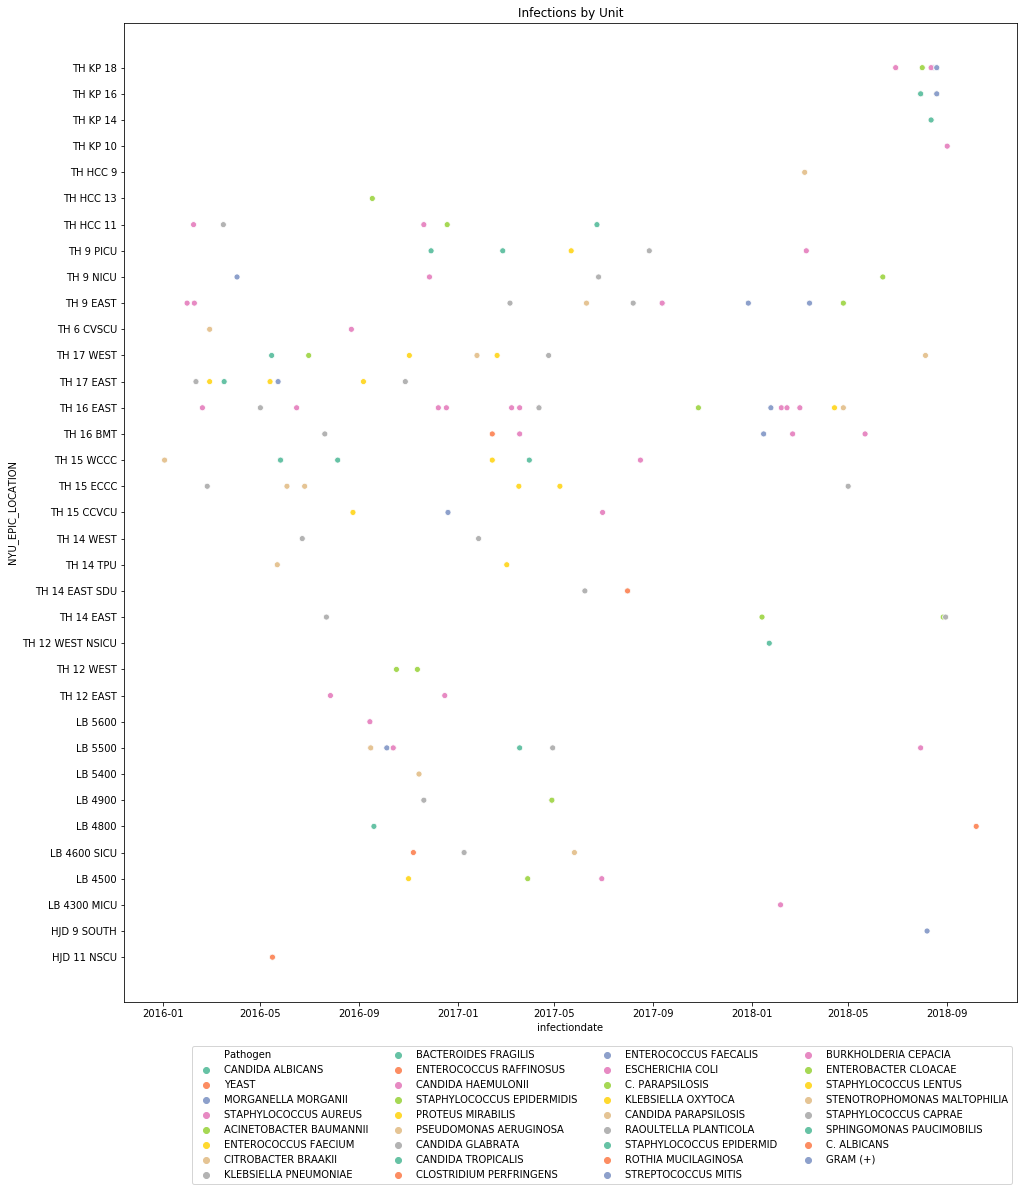

In [147]:
columns = ["infectiondate","NYU_EPIC_LOCATION","Pathogen"]
df = pd.read_excel("clabsi.xlsx")
frame = df[columns]

date = frame["infectiondate"]
date = pd.to_datetime(date)
frame["infectiondate"] = date.values
fig, ax = plt.subplots(figsize=(16,18))
frame = tidy_split(frame,"Pathogen",";")
frame = frame.sort_values(by=["NYU_EPIC_LOCATION","Pathogen"])
frame = frame.reset_index(drop=True)
#print(frame)

sns_plot = sns.scatterplot("infectiondate","NYU_EPIC_LOCATION",data=frame,hue="Pathogen",ax=ax,palette="Set2")
plt.title("Infections by Unit")
plt.legend(loc='upper right',bbox_to_anchor=(1,-.04),ncol=4)
plt.savefig("pathogens_by_unit.png")


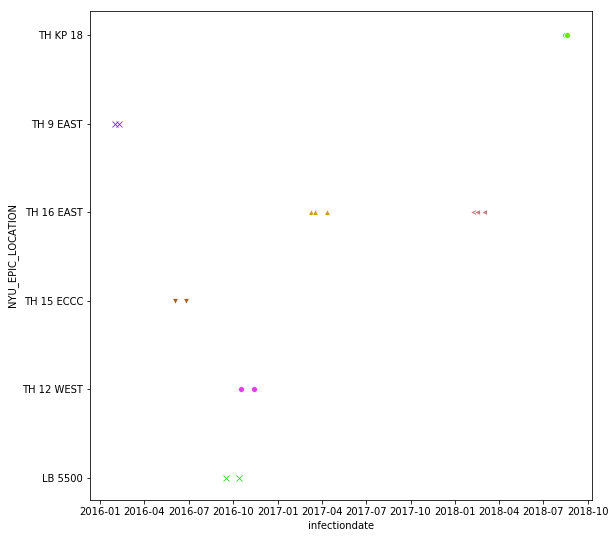

In [143]:
#print(frame)

def naive_infection_cluster(frame,window):
    clusters = []
    frame = frame.sort_values(by=["NYU_EPIC_LOCATION","Pathogen","infectiondate"]).reset_index(drop=True)
    grouped = frame.groupby(["NYU_EPIC_LOCATION","Pathogen"])
#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         print(frame)
    groups = grouped.groups
    for group in groups:
        index = groups[group]
        #print(index[0],index[-1])
        floor = frame.iloc[index[0]:index[-1]+1]
        #print(floor,"\n\n")
        prevInfection = None
        currInfection = None
        total = 0
        count = 0
        indices = []
        for row in floor.iterrows():
            prevInfection = currInfection
            currInfection = row
            if(prevInfection != None):
                #print(currInfection[0])
                d = (currInfection[1][0] - prevInfection[1][0]).days
                if(total+d < window*(count+1)):
                    count += 1
                    total += d
                    indices.append(prevInfection[0])
                    indices.append(currInfection[0])
                else:
                    total = 0
                    count = 0
                    if(indices != []):
                        clusters.append(frame.iloc[indices[0]:indices[-1]+1])
                    indices = []
        if(indices != []):
            clusters.append(frame.iloc[indices[0]:indices[-1]+1])

    #print(clusters)
    return clusters
                    
                #print(d)

clusters = naive_infection_cluster(frame,31)
fig, ax = plt.subplots(figsize=(9,9))
colors = np.random.random((len(clusters),3))
markers = ['x','o','v','^','<']*100
for i in range(len(clusters)):
    sns_plot = sns.scatterplot("infectiondate","NYU_EPIC_LOCATION",data=clusters[i],color=colors[i], marker=markers[i],ax=ax)

sns_plot.get_figure().savefig("pathogens_by_unit_clustered.png")


In [52]:
# #pathogen_dummies = pd.get_dummies(frame["Pathogen"])
# #loc_dummies = pd.get_dummies(frame["NYU_EPIC_LOCATION"])
# knn_frame = pd.get_dummies(frame[["Pathogen","NYU_EPIC_LOCATION"]])#pd.concat([pathogen_dummies,loc_dummies])
# #knn_frame
# from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(knn_frame)
# distances, indices = nbrs.kneighbors(knn_frame)
